## Download data from here:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


chest_xray_data/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── val/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── test/
    ├── NORMAL/
    └── PNEUMONIA/

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [4]:
# Parameters

BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Data transforms

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
# Data loaders

data_dir = "chest_xray_data"
train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_ds = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_ds = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [9]:
# Simple CNN model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE//8) * (IMG_SIZE//8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# Training loop with accuracy tracking

train_accs, val_accs = [], []
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    train_accs.append(correct / total)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")

Epoch 1: Train Acc=0.8900, Val Acc=0.5000
Epoch 2: Train Acc=0.9557, Val Acc=0.8125
Epoch 3: Train Acc=0.9643, Val Acc=0.6250
Epoch 4: Train Acc=0.9676, Val Acc=0.6250
Epoch 5: Train Acc=0.9732, Val Acc=0.9375
Epoch 6: Train Acc=0.9714, Val Acc=0.7500
Epoch 7: Train Acc=0.9737, Val Acc=0.9375
Epoch 8: Train Acc=0.9751, Val Acc=0.9375
Epoch 9: Train Acc=0.9789, Val Acc=0.8125
Epoch 10: Train Acc=0.9814, Val Acc=0.8750


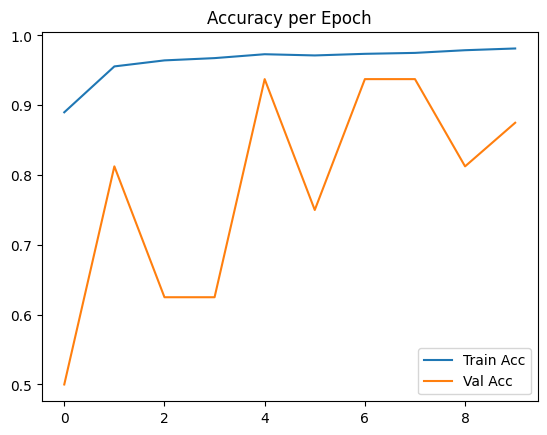

In [11]:
# Accuracy chart

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

In [12]:
# Test evaluation Metrics
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x).argmax(1).cpu()
        all_preds.extend(pred.tolist())
        all_labels.extend(y.tolist())

print(classification_report(all_labels, all_preds, target_names=test_ds.classes))

              precision    recall  f1-score   support

      NORMAL       0.99      0.44      0.61       234
   PNEUMONIA       0.75      1.00      0.85       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.73       624
weighted avg       0.84      0.79      0.76       624



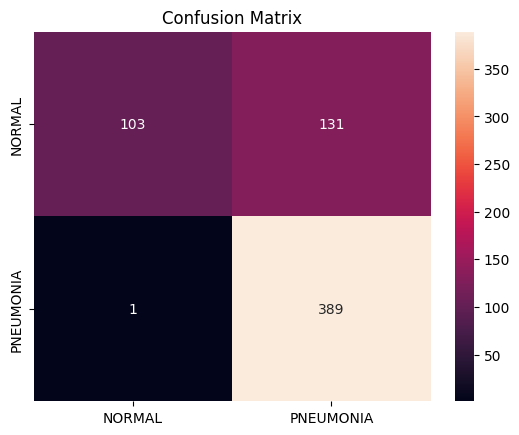

In [13]:
# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title("Confusion Matrix")
plt.show()